# Hand Gesture Transformer – Training notebook

이 노트북은 Mediapipe로 추출한 21개 손 랜드마크(3‑D)를 Transformer Encoder에 넣어 4‑클래스 손동작을 분류하는 모델을 학습합니다.

* Train : Val = 80 : 20
* 결과: 에포크별 loss & accuracy 그래프, action별 Attention heat‑map 시각화


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from models.model import GestureModel
import seaborn as sns
from config import GESTURE

In [ ]:
class Settings:
    window_size = 30
    batch_size = 64
    epochs = 15
    learning_rate = 0.0001
    dataset_dir = './json_data/'
    model_save_dir = './checkpoint/'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_classes = len(GESTURE)     # 8 Gestures + No Action
    seed = 42

os.makedirs(Settings.model_save_dir, exist_ok=True)
ckpt_path = os.path.join(Settings.model_save_dir, "best.pth")

In [3]:
class GestureDataset(Dataset):
    def __init__(self, folder_dir, window_size=30):
        self.window_size = window_size
        self.data = []
        self.labels = []
        self._load_data(folder_dir)

    def _load_data(self, folder_dir):
        for file in os.listdir(folder_dir):
            if file.endswith('.json'):
                filepath = os.path.join(folder_dir, file)
                with open(filepath, 'r') as f:
                    content = json.load(f)
                    samples = content['samples']

                    joints = [np.array(sample['joint']) for sample in samples]
                    joints = np.array(joints) - joints[0]
                    labels = [sample['label'] for sample in samples]

                    for i in range(len(joints) - self.window_size + 1):
                        window = joints[i:i+self.window_size]
                        label = labels[i+self.window_size-1]

                        window = np.stack(window, axis=0)
                        self.data.append(window)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

In [4]:
# dataset = GestureDataset(Settings.dataset_dir, Settings.window_size)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=Settings.batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=Settings.batch_size, shuffle=False)

In [5]:
dataset = GestureDataset(Settings.dataset_dir, Settings.window_size)

n_total = len(dataset)
n_train = int(n_total * 0.7)
n_val   = int(n_total * 0.2)
n_test  = n_total - n_train - n_val

train_set, val_set, test_set = random_split(
    dataset, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(Settings.seed)
)

train_loader = DataLoader(train_set, batch_size=Settings.batch_size,
                          shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=Settings.batch_size,
                          shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=Settings.batch_size,
                          shuffle=False, num_workers=4, pin_memory=True)

In [6]:
model = GestureModel(n_cls=Settings.num_classes).to(Settings.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Settings.learning_rate)

In [7]:
def run(loader, train=True):
    model.train(train)
    tot, correct, loss_sum = 0,0,0.0
    for x,y in tqdm(loader, leave=False):
        x,y = x.to(Settings.device), y.to(Settings.device)
        if train: optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        if train:
            loss.backward()
            optimizer.step()
        pred = out.argmax(1)
        tot += y.size(0); correct += (pred==y).sum().item()
        loss_sum += loss.item()*y.size(0)
    return loss_sum/tot, correct/tot

In [8]:
best = 0.0
best_epoch = 0
for ep in range(1, Settings.epochs+1):
    train_loss, train_acc = run(train_loader,True)
    val_loss ,val_acc = run(val_loader,False)
    print(f"[{ep}] train loss:{train_loss:.4f} | accuracy:{train_acc:.3f}\nval loss:{val_loss:.4f} | accuracy:{val_acc:.3f}")
    if val_acc > best:
        best = val_acc
        best_epoch = ep
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ↳ best saved ({best:.3f})")

print(f"\nBest accuracy = {best:.3f} (epoch {best_epoch})")

[1] train loss:1.7358 | accuracy:0.289
val loss:1.1076 | accuracy:0.546
  ↳ best saved (0.546)


[2] train loss:0.7696 | accuracy:0.701
val loss:0.6817 | accuracy:0.748
  ↳ best saved (0.748)


[3] train loss:0.5100 | accuracy:0.806
val loss:0.4202 | accuracy:0.839
  ↳ best saved (0.839)


[4] train loss:0.3756 | accuracy:0.857
val loss:0.3768 | accuracy:0.850
  ↳ best saved (0.850)


[5] train loss:0.3408 | accuracy:0.862
val loss:0.2786 | accuracy:0.904
  ↳ best saved (0.904)


[6] train loss:0.2812 | accuracy:0.892
val loss:0.2436 | accuracy:0.896


[7] train loss:0.2761 | accuracy:0.900
val loss:0.1413 | accuracy:0.962
  ↳ best saved (0.962)


[8] train loss:0.2190 | accuracy:0.927
val loss:0.1384 | accuracy:0.959


[9] train loss:0.1371 | accuracy:0.957
val loss:0.3797 | accuracy:0.870


[10] train loss:0.1469 | accuracy:0.954
val loss:0.1673 | accuracy:0.948


[11] train loss:0.0797 | accuracy:0.979
val loss:0.0749 | accuracy:0.976
  ↳ best saved (0.976)


[12] train loss:0.0965 | accuracy:0.970
val loss:0.0422 | accuracy:0.990
  ↳ best saved (0.990)


[13] train loss:0.0524 | accuracy:0.985
val loss:0.0515 | accuracy:0.984


[14] train loss:0.0714 | accuracy:0.977
val loss:0.0699 | accuracy:0.976


[15] train loss:0.0385 | accuracy:0.988
val loss:0.0278 | accuracy:0.991
  ↳ best saved (0.991)

Best accuracy = 0.991 (epoch 15)


In [9]:
model.load_state_dict(torch.load(ckpt_path))
test_loss, test_acc = run(test_loader, False)
print(f"Test loss:{test_loss:.4f} | accuracy:{test_acc:.3f}")

  0%|          | 0/13 [00:00<?, ?it/s]

Test loss:0.0229 | accuracy:0.994


In [10]:
# 5-1. 어텐션을 반환하는 모델 로드
viz_model = GestureModel(n_cls=Settings.num_classes, return_attn=True).to(Settings.device)
viz_model.load_state_dict(torch.load(ckpt_path, map_location=Settings.device))
viz_model.eval()

# 5-2. 검증 세트 첫 배치를 하나 가져옴
val_iter = iter(val_loader)
frames, lbl = next(val_iter)
frames = frames[:1].to(Settings.device)      # (1,30,21,3)

with torch.no_grad():
    logits, attn_list = viz_model(frames)      # attn_list[-1]: (B*30, h, 22, 22)

# 5-3. 텐서 형태 변환 → (B,30,h,22,22)
last_layer = attn_list[-1]
B,T = 1, Settings.window_size
h = last_layer.size(1)
heat = last_layer.view(B, T, h, 22, 22)[0, 0, 0].cpu()   # (22,22) 첫 프레임·첫 헤드

In [11]:
import random, torch, matplotlib.pyplot as plt, seaborn as sns
import numpy as np

# ──────────────────────────────────────────────────────────────
# Mediapipe 손가락 구간 (엄지 1~4, 검지 5~8, 중지 9~12, 약지 13~16, 소지 17~20)
FINGER_SPLITS = [1, 5, 9, 13, 17, 22]   # 축 그리드 선 위치
# ──────────────────────────────────────────────────────────────

def _draw_heat(ax, heat, title, vmin=None, vmax=None):
    """축(ax)에 히트맵 1장을 그린다."""
    sns.heatmap(
        heat.cpu().numpy(),
        cmap='viridis',
        vmin=vmin, vmax=vmax,          # 공통 범위 or 개별
        xticklabels=range(22),
        yticklabels=list(range(22))[::-1],
        linewidths=.4, linecolor='white',
        square=True, cbar=True, cbar_kws={'shrink': .7},
        ax=ax
    )
    # 손가락 구분선
    for cut in FINGER_SPLITS:
        ax.axhline(cut, color='black', lw=.5)
        ax.axvline(cut, color='black', lw=.5)
    ax.set_title(title, fontsize=11, pad=8)
    ax.set_xlabel("Key", fontsize=8); ax.set_ylabel("Query", fontsize=8)
    ax.tick_params(labelsize=6, rotation=0)

def visualize_label_heatmaps(
        target_idx: int,
        gesture: dict,
        loader,                 # 검증 DataLoader
        model_with_attn,        # return_attn=True 모델
        n_samples: int = 4,
        head: int = 0,
        layer: int = -1,
        device: torch.device = torch.device('cpu')):
    """
    target_idx   : 보고 싶은 레이블 인덱스
    loader       : DataLoader (shuffle=False 권장)
    model_with_attn : best 모델. forward → (logits, attn_list)
    n_samples    : 히트맵 몇 장 볼지
    head, layer  : 추출할 헤드·레이어
    """

    # ── 1) 해당 레이블 인덱스 수집 ───────────────────────────
    idx_pool = [i for i, (_, y) in enumerate(loader.dataset) if y == target_idx]
    if not idx_pool:
        print(f"Label {target_idx} 샘플이 loader에 없습니다."); return
    pick = random.sample(idx_pool, min(n_samples, len(idx_pool)))

    # ── 2) 공통 vmin/vmax 계산 (절대 비교용) ───────────────
    heat_list = []
    model_with_attn.eval()
    for ds_idx in pick:
        frame, _ = loader.dataset[ds_idx]      # (30,21,3)
        frame = frame.unsqueeze(0).to(device)
        with torch.no_grad():
            _, attn = model_with_attn(frame)
        heat = attn[layer][0, head]            # (22,22)
        heat_list.append(heat)
    vmin = min(h.min().item() for h in heat_list)
    vmax = max(h.max().item() for h in heat_list)

    # ── 3) 2×2 서브플롯 그리기 ───────────────────────────
    rows = (len(heat_list) + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(12, 4.5 * rows),
                             constrained_layout=True)
    axes = axes.flatten()

    for k, (heat, ds_idx) in enumerate(zip(heat_list, pick)):
        _draw_heat(
            axes[k],
            heat,
            title=f"idx {ds_idx}   L{layer}·H{head}   "
                  f"Label {target_idx}: {gesture.get(target_idx, 'Unknown')}",
            vmin=vmin, vmax=vmax
        )

    # 남는 축 숨기기
    for ax in axes[len(heat_list):]:
        ax.axis('off')

    plt.show()

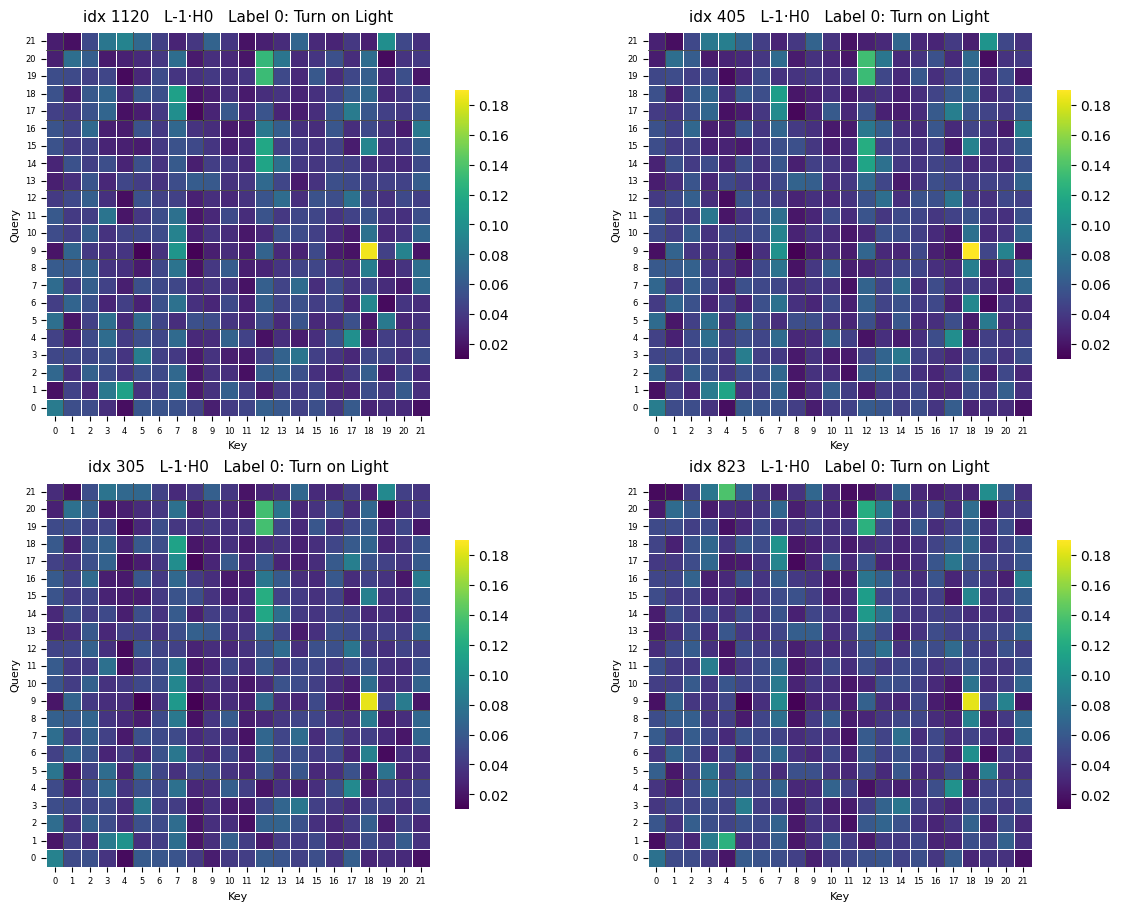

In [12]:
target_idx = 0
visualize_label_heatmaps(
    target_idx=target_idx,
    gesture=GESTURE,
    loader=val_loader,          # ← 검증 DataLoader
    model_with_attn=viz_model,  # ← return_attn=True 로 로드된 best 모델
    n_samples=4,
    head=0,
    layer=-1,
    device=Settings.device
)